In [26]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [27]:
memory = MemorySaver()

search_tool = TavilySearch(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

In [28]:
class BasicState(TypedDict): 
    messages: Annotated[List, add_messages]

In [29]:
def model(state: BasicState): 
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

In [30]:
def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and 
    len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return "stop"

In [31]:
graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router,{
    "tools":"tools",
    "stop":END
})

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

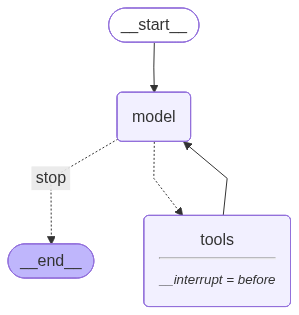

In [32]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
config = {"configurable": {
    "thread_id": 3
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Kolkata?")]
}, config=config, stream_mode="values")

for event in events:
    # event["messages"][-1].pretty_print()
    print(event)
    for node_id, value in event.items():
        print(node_id)

{'messages': [HumanMessage(content='What is the current weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='2a53eff1-732a-45f3-ae3e-5d6b7239d5d5'), HumanMessage(content='What is the current weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='36fd7a41-bbd0-42a1-bca4-0cbed470e3dc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'hy1m4c27f', 'function': {'arguments': '{"include_favicon":true,"include_images":true,"query":"Current weather in Kolkata","search_depth":"advanced","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2115512ff6', 'service_tier': 'on_demand'}, id='run--f18dca10-56d4-42a5-8270-9c8cf5e5a954', tool_calls=[{'name': 'tavily_search', 'args': {'include_favicon': True, 'include_images': True, 'query': 'Current weather in Kolkata', 'search_depth': 'advanced', 'topic': 'news'}, 'id':

In [21]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [38]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (daf0c7v2d)
 Call ID: daf0c7v2d
  Args:
    exclude_domains: ['weather.com']
    include_favicon: False
    include_images: True
    query: Current weather in Kolkata
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Current weather in Kolkata", "follow_up_questions": null, "answer": null, "images": ["https://static.tnn.in/photo/msid-109103461/109103461.jpg", "https://localharyana.com/wp-content/uploads/2024/09/Kolkata-Weather-Update.jpg", "https://imgeng.jagran.com/images/2023/sep/rain+(2)1695539654858.jpg", "https://static.tnn.in/thumb/msid-110815777,thumbsize-36522,width-1280,height-720,resizemode-75/110815777.jpg", "https://www.timeanddate.com/scripts/cityog.php?title=14-Day+Weather+Forecast+for&tint=0x007b7a&city=Kolkata&state=West+Bengal&country=India&image=kolkata1"],

In [39]:
for even in events:
    print(event)